In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [12]:
import sys
sys.path.append("/home/ubuntu/bin/autoencoders")

from dataloader import MNISTDataLoader, DataLoaderConfig
from autoencoder import AutoEncoder, ModelConfig
from train import Config

config = Config(
    model_config=ModelConfig(
        hidden_dim=[32, 64, 128, 256],
        latent_dim=128,
        in_channels=1,
        image_size=32,
    ),
    dataloader_config=DataLoaderConfig(
        batch_size=16, num_workers=4, image_size=32, download=True, data_root="../data"
    ),
)

In [11]:
dataloader_config = config.dataloader_config
dataloader = MNISTDataLoader(dataloader_config)
_, test_loader = dataloader.get_data_loaders()

INFO:dataloader:Initialized MNISTDataLoader with config: DataLoaderConfig(batch_size=16, num_workers=4, train_data=True, shuffle_train=True, shuffle_test=False, data_root='./data', image_size=32, normalize_mean=0.5, normalize_std=0.5, download=True)
INFO:dataloader:Data directory ensured at: ./data
INFO:dataloader:Loading MNIST datasets...
100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 433kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.04MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.07MB/s]
INFO:dataloader:Loaded 60000 training samples and 10000 test samples
INFO:dataloader:Created data loaders - Train batches: 3750, Test batches: 625


In [13]:
test_images = next(iter(test_loader))[0]
print(test_images.shape)

torch.Size([16, 1, 32, 32])


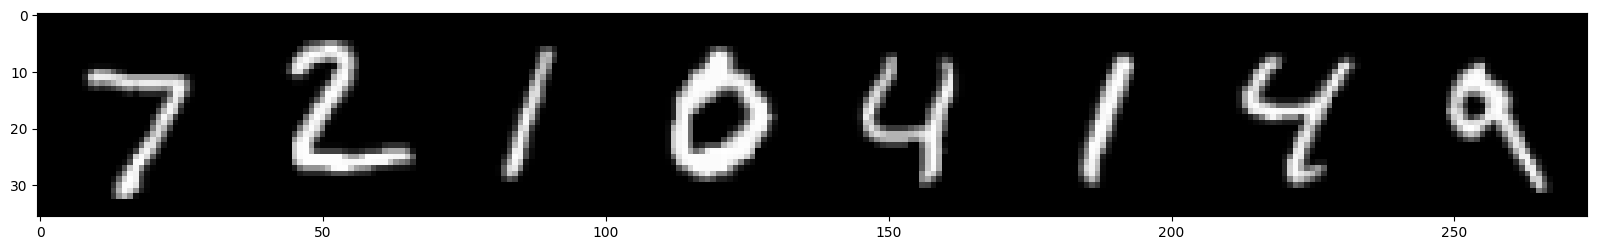

In [14]:
# Ground Truth Images:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

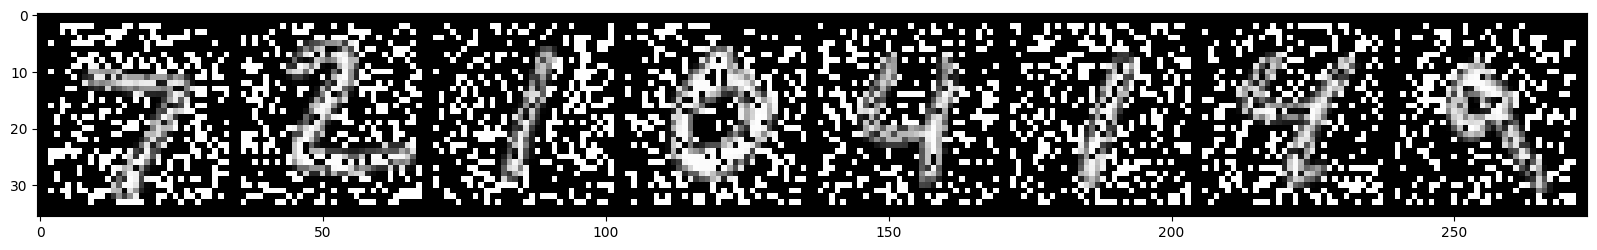

In [15]:
# Noisy Images:
noise_level = 0.3
test_images = next(iter(test_loader))[0]
plt.figure(figsize = (20,10))
noise = (torch.bernoulli((1 - noise_level) * torch.ones_like(test_images)) * 2) - 1
noisy_images = test_images * noise

out = vutils.make_grid(noisy_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [16]:
# Load the trained model:
ae = AutoEncoder(config.model_config)

checkpoint = torch.load(
    "/home/ubuntu/bin/autoencoders/logs/autoencoder_final.pth", 
    map_location='cpu', 
    weights_only=False
)
ae.load_state_dict(checkpoint['model_state_dict'])

print(f"Model has {sum(p.numel() for p in ae.parameters())} parameters")

ae.eval()

INFO:autoencoder:AutoEncoder created with 1,040,129 parameters


Model has 1040129 parameters


AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
    )
    (fc_out): Linear(in_features=1024, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc_in): Linear(in_features=128,

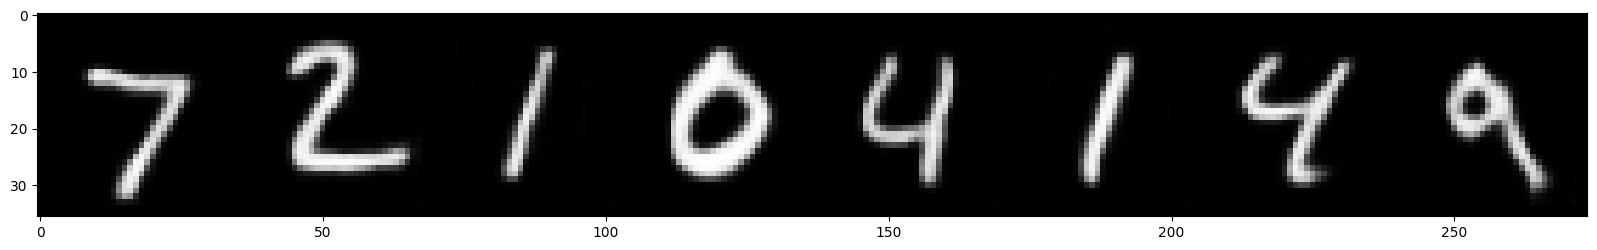

In [17]:
# Reconstruction of the noisy images:
recon_images, encoded_data = ae(noisy_images)

plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

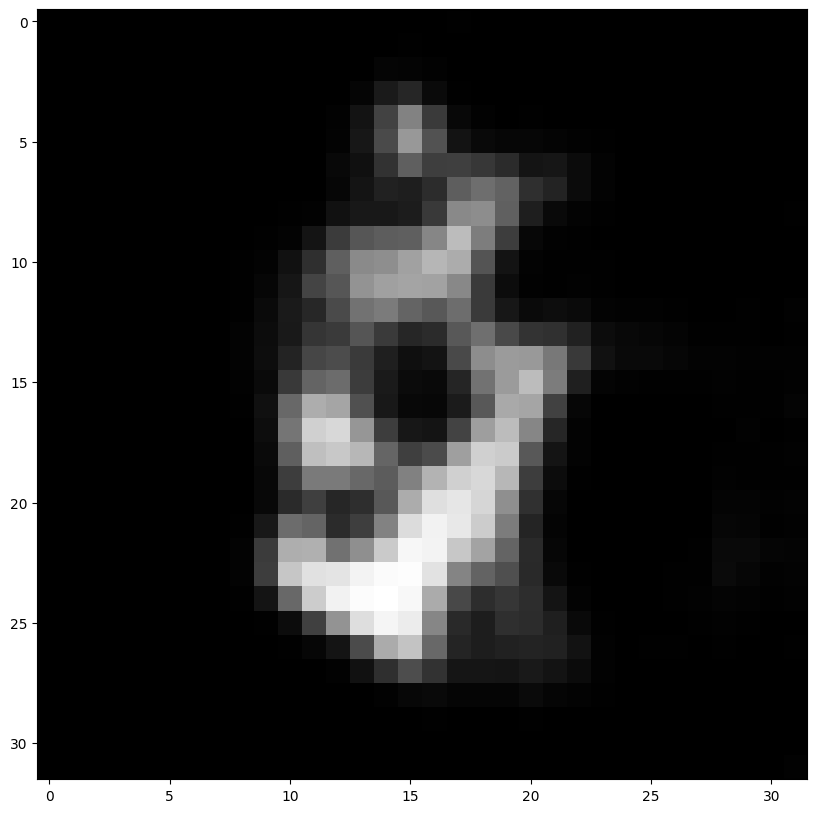

In [18]:
# Reconstruction of the noisy images:
recon_data = ae.decoder(
    encoded_data.std(0, keepdim=True) * torch.randn_like(encoded_data.std(0, keepdim=True)) + 
    encoded_data.mean(0, keepdim=True))
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))